In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define main data processing functions

In [2]:

def print_forces(forces_dict, center_positions, labeled_matrix, scale):
    centers_x, centers_y, total_forces_x, total_forces_y = [], [], [], []

    for value in center_positions.values():
        centers_x.append(value[0])
        centers_y.append(value[1])

    for force in forces_dict.values():
        total_forces_x.append(force['x']*1e3)
        total_forces_y.append(force['y']*1e3)

    # Convert lists to numpy arrays
    centers_x, centers_y = np.array(centers_x), np.array(centers_y)
    total_forces_x, total_forces_y = np.array(total_forces_x), np.array(total_forces_y)

    # Calculate magnitude of forces for color coding
    force_magnitudes = np.sqrt(total_forces_x**2 + total_forces_y**2)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # Quiver plot with color coding based on force magnitude
    quiver = ax.quiver(centers_x, centers_y, total_forces_x, total_forces_y, force_magnitudes,
                       angles='xy', scale_units='xy', scale=5/scale, cmap='viridis')

    # Optional: Add a colorbar
    fig.colorbar(quiver, ax=ax, label='Magnitude das Forças x$10^{3}$')

    # Additional plot settings
    colors = ['white'] + ['#9A9594'] * (max(int(x) for x in forces_dict.keys()) + 1)
    cmap = mcolors.ListedColormap(colors)
    ax.imshow(np.array(labeled_matrix).T, alpha=1, cmap=cmap)
    ax.set_facecolor('white')# Show islands as background
    ax.set_title('Campo de Forças nos Elementos')
    ax.set_ylim(ax.get_ylim()[::-1])  # Invert y-axis
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    return fig

def moving_mean(data, window_size):
    """Calculate the moving mean with a specified window size."""
    if len(data) < window_size:
        # If the data length is less than the window size, return the mean of the entire data
        return [np.mean(data)] * len(data)
    
    means = np.convolve(data, np.ones(window_size), 'valid') / window_size
    # To align with the center of the window, pad the beginning of the means array
    pad_size = window_size // 2
    return np.pad(means, (pad_size, len(data) - len(means) - pad_size), mode='edge')

# Calculate necessary data

In [ ]:
for i in range(5):
    for j in range(3):
        with open(f'data/data_dicts{i+1}_{j+1}.json') as file:
          
            data = json.load(file)
            labeled = np.load(f'data/labeled_matrix{i+1}_1.npy')
            labeled = labeled[:,0:400]
            scale = 10**j if j!=2 else 10**3
            fig = print_forces(data[f"forces{i+1}_{j+1}"],data[f"center_positions{i+1}_{j+1}"],labeled,scale)
            
            fig.savefig(f'data/forces{i+1}_{j+1}',dpi=300,bbox_inches='tight')

# Generate Results

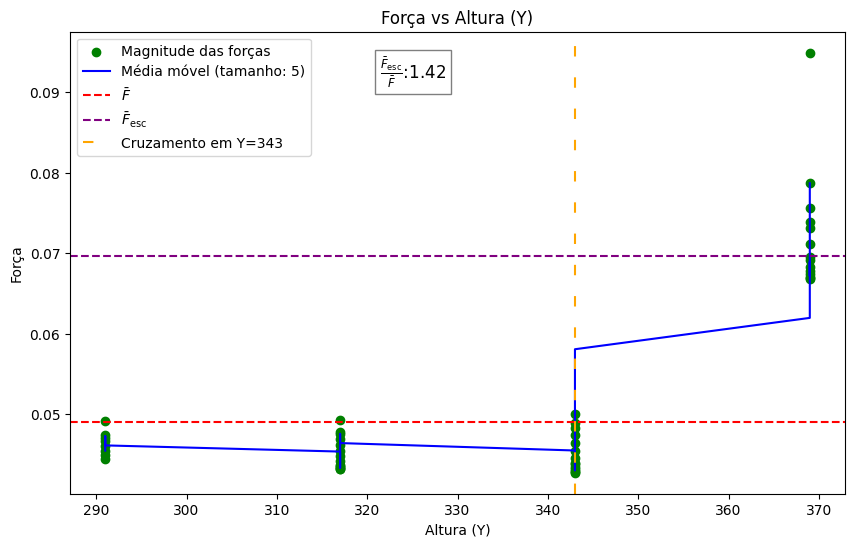

data/upper_forces_1_1
Fesc= 0.06959044324793581
F= 0.04904102941783058


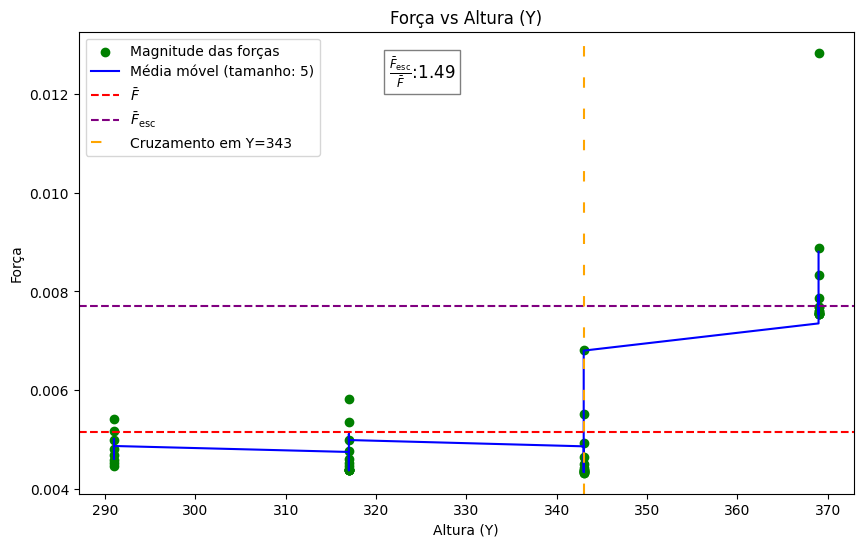

data/upper_forces_1_2
Fesc= 0.007698101220695485
F= 0.005150376085296627


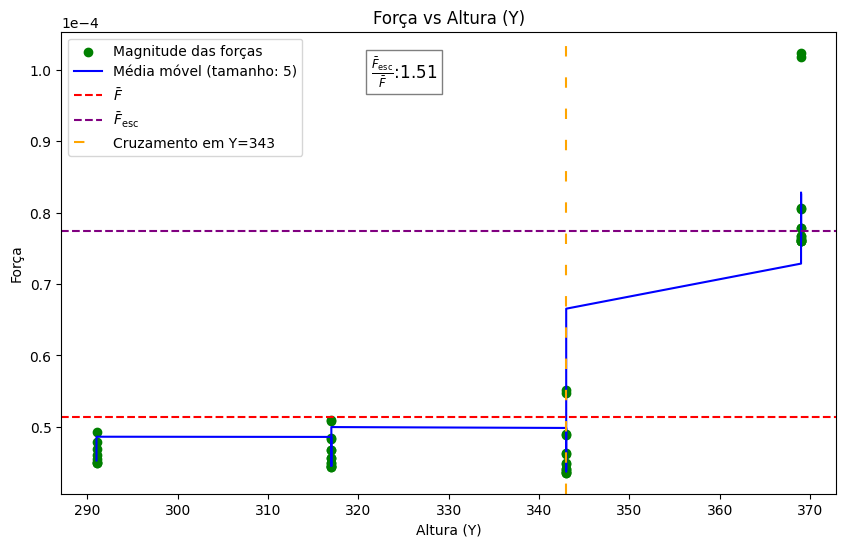

data/upper_forces_1_3
Fesc= 7.743639078945111e-05
F= 5.139220741032163e-05


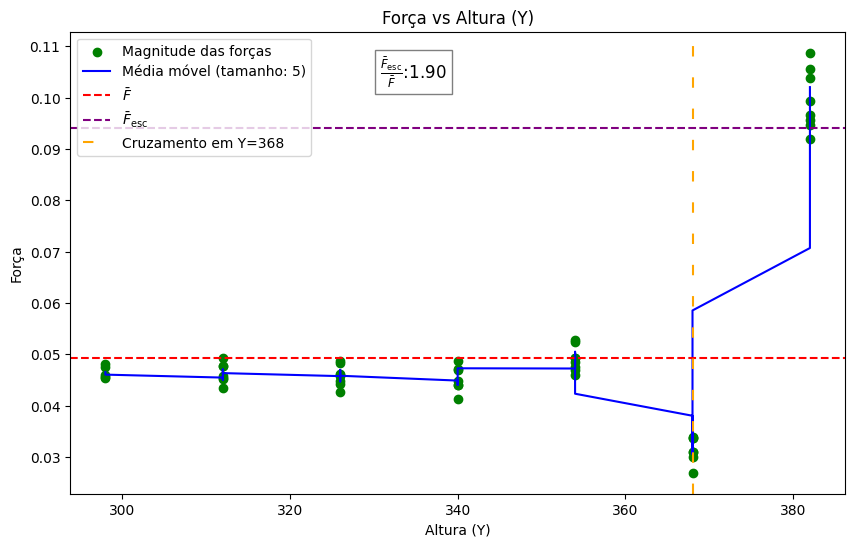

data/upper_forces_2_1
Fesc= 0.0939932087731154
F= 0.049389822748310226


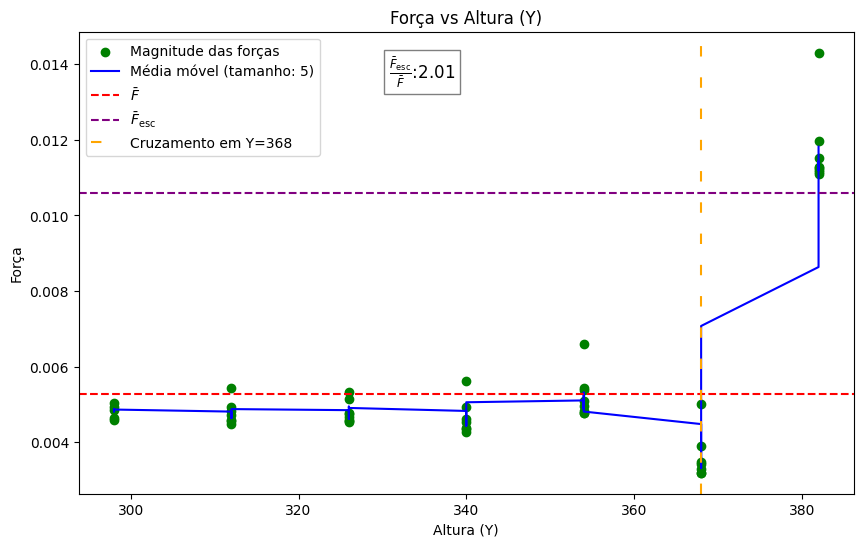

data/upper_forces_2_2
Fesc= 0.010585208981094163
F= 0.005268862961845601


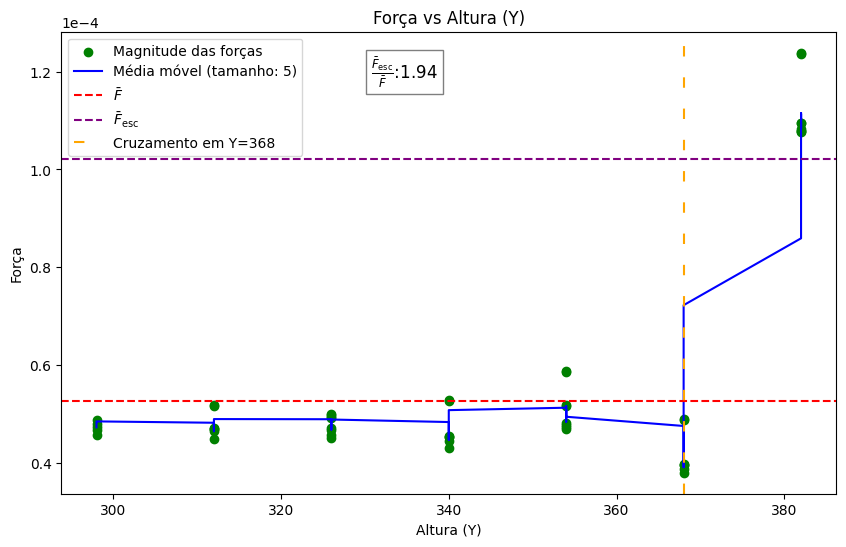

data/upper_forces_2_3
Fesc= 0.00010223928768704976
F= 5.2626043180196087e-05


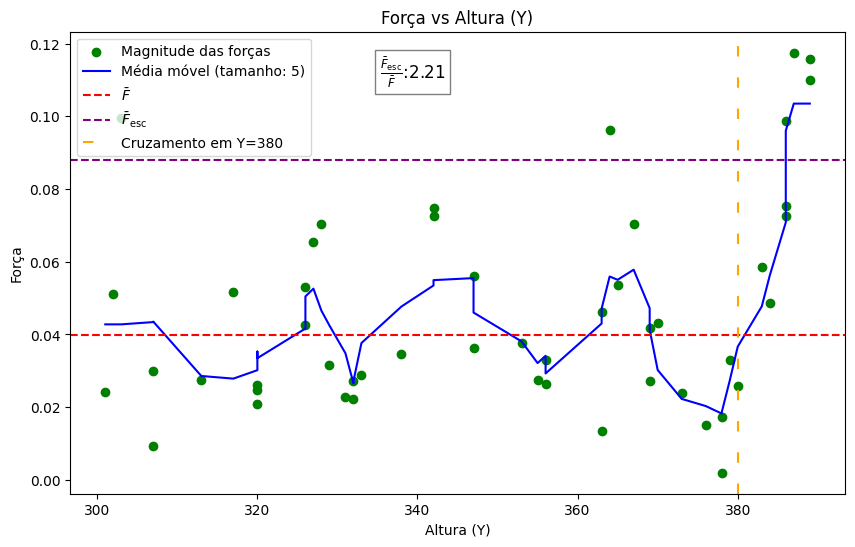

data/upper_forces_3_1
Fesc= 0.08802179585392049
F= 0.03976863113332013


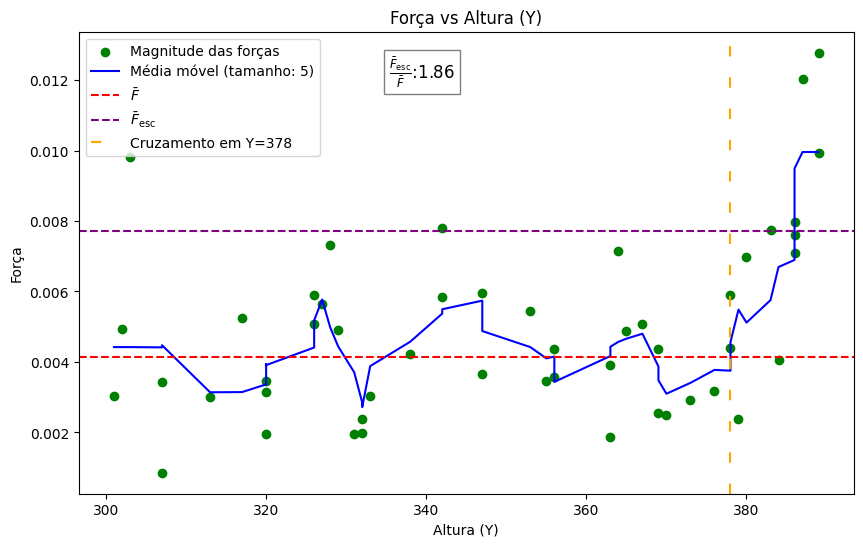

data/upper_forces_3_2
Fesc= 0.007705136521944671
F= 0.004147574587110358


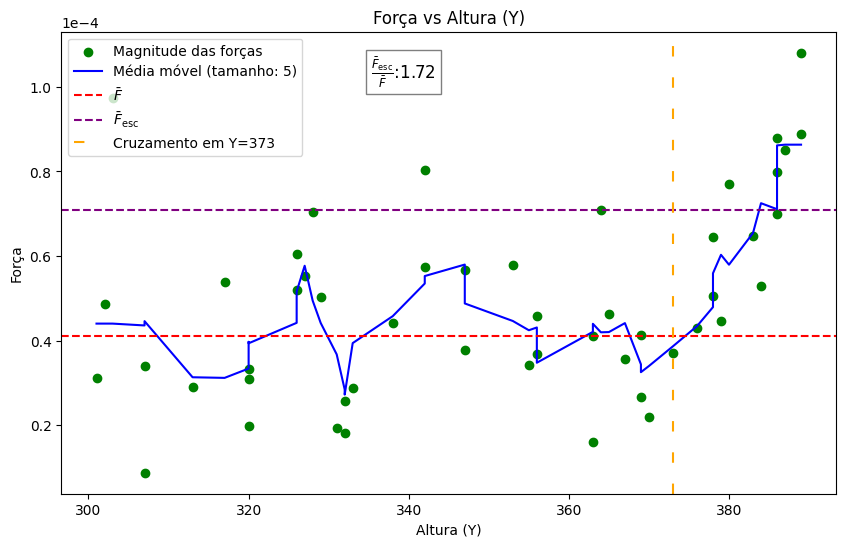

data/upper_forces_3_3
Fesc= 7.096199048013762e-05
F= 4.117512382774921e-05


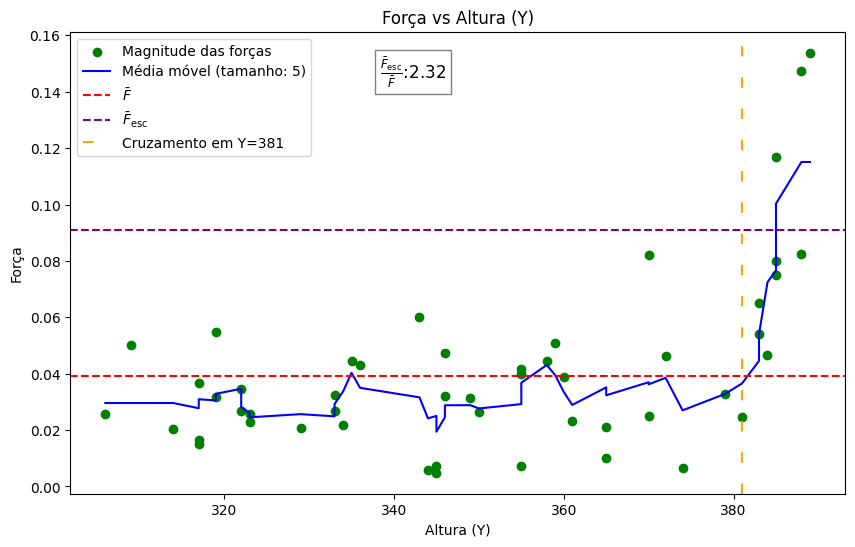

data/upper_forces_4_1
Fesc= 0.0910988202135869
F= 0.039236182478869265


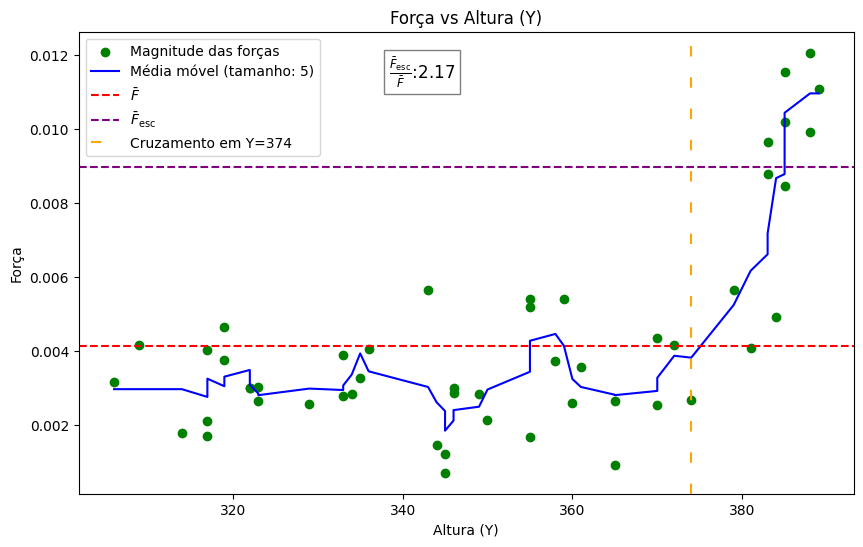

data/upper_forces_4_2
Fesc= 0.008972571289101694
F= 0.004133762125474137


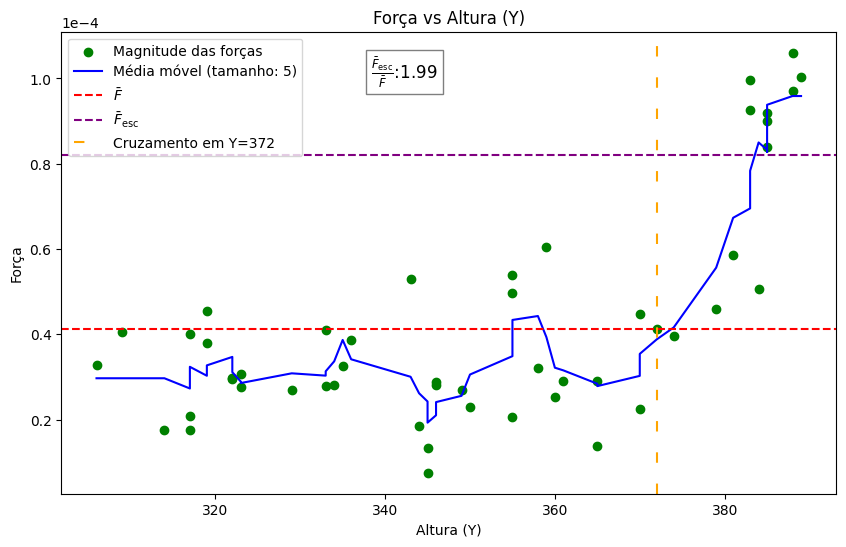

data/upper_forces_4_3
Fesc= 8.211896401201475e-05
F= 4.11683817328504e-05


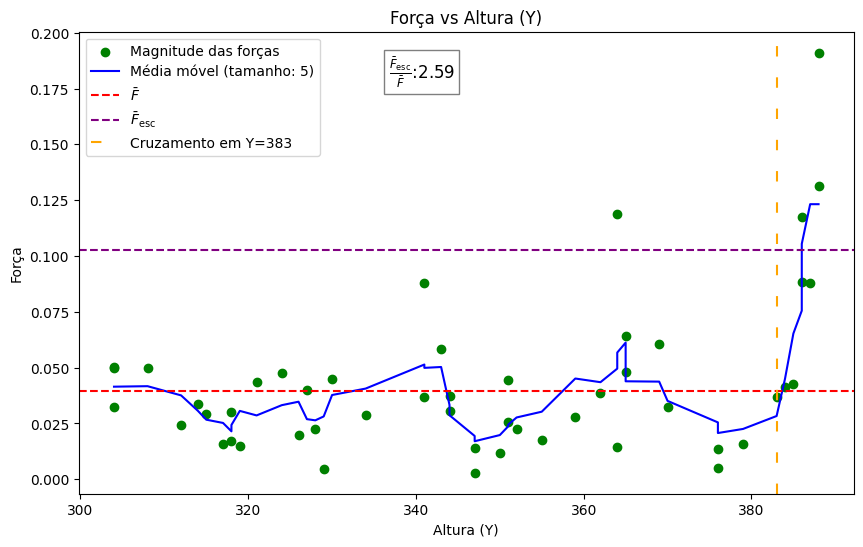

data/upper_forces_5_1
Fesc= 0.10263826500286481
F= 0.03960372625124936


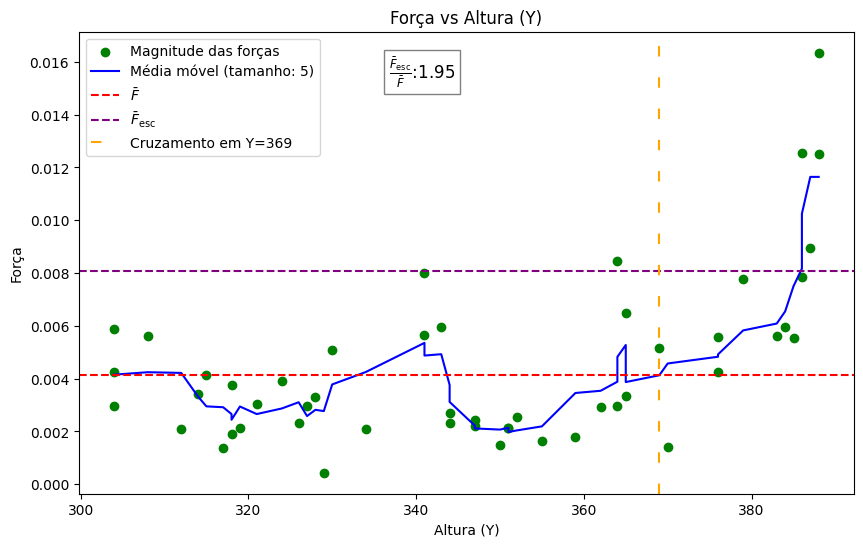

data/upper_forces_5_2
Fesc= 0.008095504067110156
F= 0.004154277572200216


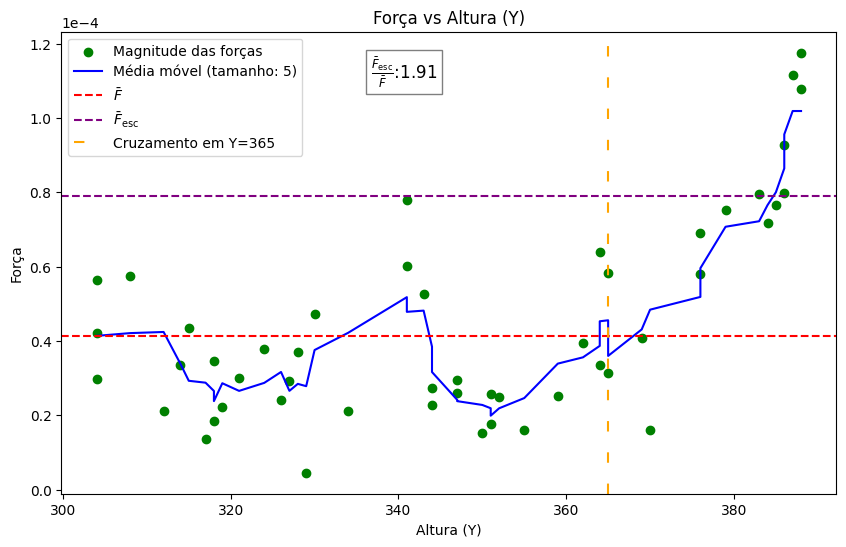

data/upper_forces_5_3
Fesc= 7.889293178501575e-05
F= 4.140264478932171e-05


In [15]:
for i in range(5):
    for j in range(3):
        with open(f'data/data_dicts{i+1}_{j+1}.json') as file:
          
            data = json.load(file)
            labeled = np.load(f'data/labeled_matrix{i+1}_1.npy')
            labeled = labeled[:,0:400]
            
            center_positions = data[f"center_positions{i+1}_{j+1}"]
            sorted_positions = sorted(center_positions.items(), key=lambda x: x[1][1], reverse=True)
            
            
            sorted_indices = [index for index, _ in sorted_positions[:50]]
            
            forces = data[f"forces{i+1}_{j+1}"]
            
            all_force_magnitudes = [np.sqrt(forces[index]['x']**2 + forces[index]['y']**2) 
                                    for index in forces]
            
            sorted_forces = {index: forces[index] for index in sorted_indices if index in forces}
            force_magnitudes = [np.sqrt(forces[index]['x']**2 + forces[index]['y']**2) 
                            for index in sorted_indices if index in forces]
            y_values = [center_positions[index][1] for index in sorted_indices if index in center_positions]
            mean_force_magnitude = np.mean(all_force_magnitudes)
            
            moving_mean_values = moving_mean(force_magnitudes, 5)
            
            crossing_point_y = None
            crossing_point_index = None
            for idx , (y, value) in enumerate(zip(y_values, moving_mean_values)):
                if value <= mean_force_magnitude:
                    crossing_point_y = y
                    crossing_point_index = idx
                    break 
                    
            mean_force_up_to_crossing = None
            if crossing_point_index is not None:
                
                mean_force_up_to_crossing = np.mean(moving_mean_values[:crossing_point_index-1])

            # Plotting
            fig = plt.figure(figsize=(10, 6))
            plt.scatter(y_values, force_magnitudes, color='green', label='Magnitude das forças')
            plt.plot(y_values, moving_mean_values, color='blue', label=f'Média móvel (tamanho: {5})')
            plt.text(0.4, 0.95, rf'$\frac{{\bar{{F}}_{{\text{{esc}}}}}}{{\bar{{F}}}}$:{mean_force_up_to_crossing/mean_force_magnitude:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="square", alpha=0.5,facecolor="white"))
            plt.axhline(y=mean_force_magnitude, color='red', linestyle='--', label=r'$\bar{F}$')
            if mean_force_up_to_crossing is not None:
                plt.axhline(y=mean_force_up_to_crossing, color='purple', linestyle='--', label=r'$\bar{F}_{\text{esc}}$')

            if crossing_point_y is not None:
                plt.axvline(x=crossing_point_y, color='orange', linestyle=(0, (5, 10)), label=f'Cruzamento em Y={crossing_point_y:.0f}')
                
            plt.ticklabel_format(style='sci',axis='y',scilimits=(-3,3))
            plt.xlabel('Altura (Y)')
            plt.ylabel('Força')
            plt.title(f'Força vs Altura (Y)')
            plt.legend(loc='upper left')
            
            plt.show()
            
            fig.savefig(f'data/upper_forces_{i+1}_{j+1}', dpi=300,bbox_inches='tight' )
            print(f'data/upper_forces_{i+1}_{j+1}')
            print('Fesc=',mean_force_up_to_crossing)
            print('F=',mean_force_magnitude)
            
            crossing_point_y = None
            


            
            